In [1]:
import numpy as np
import pandas as pd
import arch as arch
from pathlib import Path
%matplotlib inline

In [2]:
csvpath = Path('../Resources/GSPC.csv')
sp500 = pd.read_csv(csvpath, parse_dates=True, index_col='Date')
sp500.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-01-02,740.739990,742.809998,729.549988,737.010010,737.010010,463230000
1997-01-03,737.010010,748.239990,737.010010,748.030029,748.030029,452970000
1997-01-06,748.030029,753.309998,743.820007,747.650024,747.650024,531350000
1997-01-07,747.650024,753.260010,742.179993,753.229980,753.229980,538220000
1997-01-08,753.229980,755.719971,747.710022,748.409973,748.409973,557510000


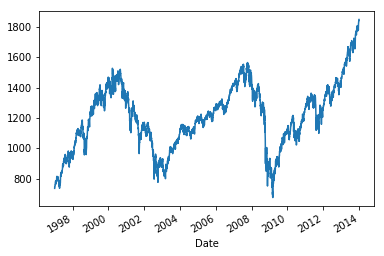

In [3]:
sp500.Close.plot()

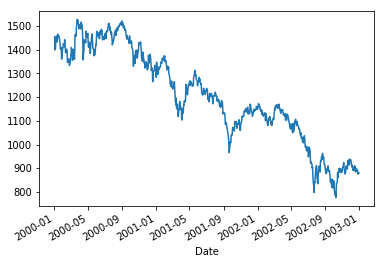

In [4]:
# September 11th attack, bursting of dot-com bubble
sp500.loc['2000':'2002'].Close.plot()

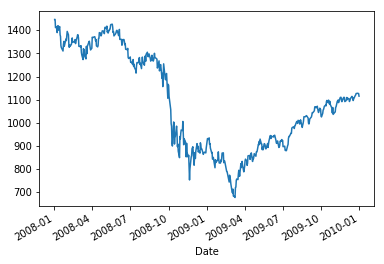

In [5]:
sp500.loc['2008':'2009'].Close.plot()

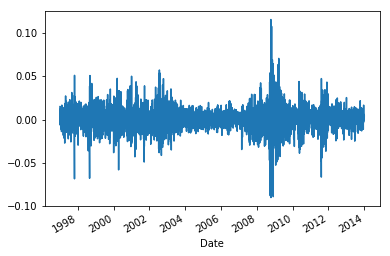

In [6]:
# GARCH assumes stationarity
# Clustering of volatility seen, e.g. 2008-2010
sp500['Close'].pct_change().plot()

In [7]:
# Focus on the 2008-2009 Financial Crisis Period
returns = sp500.loc['2008':'2009'].Close.pct_change() * 100
returns = returns.dropna()
returns.tail()

Date
2009-12-24    0.525617
2009-12-28    0.115408
2009-12-29   -0.140105
2009-12-30    0.019543
2009-12-31   -1.004960
Name: Close, dtype: float64

# GARCH

In [4]:
from arch import arch_model

In [5]:
# 'p' and 'q'  are akin to the 'p' and 'q' of an ARMA model.
# 'vol="GARCH"' means that we're using a GARCH model.
# The 'mean="Zero"' means that we're estimating a GARCH.
model = arch_model(returns, mean="Zero", vol="GARCH", p=1, q=1)

NameError: name 'returns' is not defined

In [6]:
# Fit the GARCH Model
res = model.fit(disp="off")

NameError: name 'model' is not defined

In [3]:
# Summarize the model results
res.summary()

NameError: name 'res' is not defined

In [1]:
# Plot the model estimate of annualized volatility
fig = res.plot(annualize='D')

NameError: name 'res' is not defined

# Forecasting from GARCH

In [13]:
# Construct Volatility Forecasts for the next 3 days
forecast_horizon = 3
# Take the last day of the data we used above. 
# If forecast horizon is 3, then the resulting 'h.1', 'h.2', and 'h.3' 
# are the forecasts for the following 3 days.
forecasts = res.forecast(start='2009-12-31', horizon=forecast_horizon)
forecasts

/Users/enriquebriceno/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


In [14]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate

,h.1,h.2,h.3
Date,,,
2009-12-31,13.007879,13.223021,13.43375


# Visualizing the forecast

In [15]:
# The name of the column here is the date of the forecast.
# Each row represents the forecast of volatility for the following days.
# Transposing makes the forecast easier to plot
final = intermediate.dropna().T
final

Date,2009-12-31
h.1,13.007879
h.2,13.223021
h.3,13.433750


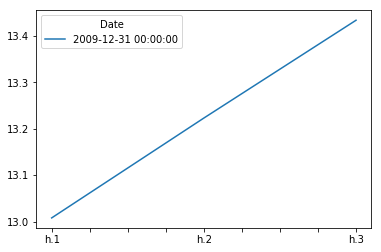

In [16]:
final.plot()